In [ ]:
import random
import json
from time import time
import numpy
import pandas as pd
import matplotlib.pyplot as plt
from deap import algorithms, base, creator, tools

# Problema del viajero

In [ ]:
with open("/work/algoritmos_geneticos/Capitulo_2/cities/gr17.json", "r") as f:
    tsp = json.load(f)

# Matriz de distancia
distance_map = tsp["DistanceMatrix"]
IND_SIZE = tsp["TourSize"]

## Creación de los objetos para definir el problema y el tipo de individuo

In [ ]:
def register_initial_components(n_population=100):
    for _class in ["FitnessMin", "Individual"]:
        if _class in dir(creator):
            delattr(creator, _class)
    
    creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
    creator.create("Individual", list, fitness=creator.FitnessMin)

    toolbox = base.Toolbox()

    # Generación del tour aleatorio
    toolbox.register("indices", random.sample, range(IND_SIZE), IND_SIZE)
    toolbox.register(
        "individual",
        tools.initIterate,
        creator.Individual,
        toolbox.indices
    )
    toolbox.register(
        "population",
        tools.initRepeat,
        list,
        toolbox.individual,
        n_population
    )
    return toolbox

## Función objetivo y operadores genéticos

In [ ]:
def eval_tsp(individual):
    """Funcion objetivo, calcula la distancia que recorre el viajero"""
    
    # Distancia entre el último elemento y el primero
    distance = distance_map[individual[-1]][individual[0]]
    # Distancia entre el resto de ciudades
    for gen1, gen2 in zip(individual[:-1], individual[1:]):
        distance += distance_map[gen1][gen2]
    return distance,

In [ ]:
# Registro de operaciones géneticas
def register_genetic_operators(toolbox):
    toolbox.register("mate", tools.cxOrdered)
    # toolbox.register("mate", tools.cxPartialyMatched)
    toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.05)
    toolbox.register("select", tools.selTournament, tournsize=5)
    toolbox.register("evaluate", eval_tsp)

    return toolbox

## Selección del algoritmo genético

*EaMuPlusLambda*: Este algoritmo se basa en que cada nueva generación se extrae a partirde la llamadapoblación extendida, que no es más que la combinación de la población actual (de tamaño μ) y la descendencia (de tamaño λ); de ahí que el algoritmo acuñe el nombre μ+λ.

![Picture title](../images/image-20220122-224719.png)

In [ ]:
def simulate(toolbox, CXPB=0.7, MUTPB=0.3, NGEN=45, verbose=False, **kwargs):
    pop = toolbox.population()

    MU, LAMBDA = len(pop), len(pop)
    hof = tools.HallOfFame(1)

    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", numpy.mean)
    stats.register("std", numpy.std)
    stats.register("min", numpy.min)
    stats.register("max", numpy.max)

    pop, logbook = algorithms.eaMuPlusLambda(
        pop,
        toolbox,
        MU,
        LAMBDA,
        CXPB,
        MUTPB,
        NGEN,
        stats=stats,
        halloffame=hof,
        verbose=verbose
    )
    return pop, logbook


In [ ]:
def plot_evolution(log):
    gen = log.select("gen")
    fit_mins = log.select("min")
    fit_maxs = log.select("max")
    fit_avg = log.select("avg")

    fig, ax1 = plt.subplots(figsize=(8,8))
    ax1.plot(gen, fit_mins, "b")
    ax1.plot(gen, fit_maxs, "r")
    ax1.plot(gen, fit_avg, "--k")
    ax1.fill_between(gen , fit_mins , fit_maxs, facecolor='g', alpha = 0.2)
    ax1.set_title("Minimizar función de Rastrigin mediante algoritmos geneticos")
    ax1.set_xlabel("Generation")
    ax1.set_ylabel("Fitness")
    # ax1.set_ylim([-1, 240])
    # ax1.set_xlim([0, 51])
    ax1.legend (["Min", "Max", "Avg"], loc="upper right")
    plt.grid(True)

In [ ]:
def run(cases):
    random.seed(100)
    results = []
    results_logs = {idx+1: [] for idx in range(len(cases))}
    for idx, case in enumerate(cases):
        toolbox = register_initial_components(case["n_population"])
        toolbox = register_genetic_operators(toolbox)
        for i in range(10):
            t0 = time()
            best, log = simulate(toolbox, **case)
            results.append([idx+1, i, case["n_population"], case["CXPB"],
                case["MUTPB"], case["NGEN"], best[0].fitness.values[0], best[0], round(time()-t0, 4)]
            )
            results_logs[idx+1].append(log)

    return pd.DataFrame(results, columns=["Test ID", "Try", "Population", "CXPB", "MUTPB", "NGEN", "Best Fitness", "Best", "Time"]), results_logs

In [ ]:
cases = (
    # {"n_population": 100, "CXPB": 0.7, "MUTPB":0.3, "NGEN": 120},
    {"n_population": 100, "CXPB": 0.8, "MUTPB":0.2, "NGEN": 50},
    # {"n_population": 100, "CXPB": 0.6, "MUTPB":0.4, "NGEN": 120},
)

In [ ]:
df, logs = run(cases)

In [ ]:
df

,Test ID,Try,Population,CXPB,MUTPB,NGEN,Best Fitness,Best,Time
0,1,0,100,0.8,0.2,50,2085.0,"[1, 9, 10, 2, 14, 13, 16, 5, 7, 6, 12, 3, 0, 1...",0.4100
1,1,1,100,0.8,0.2,50,2206.0,"[13, 14, 10, 9, 1, 4, 2, 5, 7, 6, 12, 3, 0, 15...",0.3637
2,1,2,100,0.8,0.2,50,2184.0,"[12, 6, 7, 16, 13, 14, 9, 1, 4, 10, 2, 5, 8, 1...",0.3719
3,1,3,100,0.8,0.2,50,2095.0,"[8, 4, 1, 9, 10, 2, 14, 13, 5, 7, 16, 6, 12, 3...",0.5003
4,1,4,100,0.8,0.2,50,2221.0,"[2, 14, 9, 1, 4, 10, 8, 11, 15, 0, 6, 16, 3, 1...",0.6066
5,1,5,100,0.8,0.2,50,2159.0,"[15, 0, 3, 12, 6, 16, 7, 5, 13, 14, 2, 10, 4, ...",0.6420
6,1,6,100,0.8,0.2,50,2103.0,"[6, 16, 13, 14, 9, 1, 4, 10, 2, 5, 7, 12, 3, 8...",0.6614
7,1,7,100,0.8,0.2,50,2151.0,"[10, 9, 1, 4, 2, 14, 13, 16, 12, 3, 8, 11, 15,...",0.3523
8,1,8,100,0.8,0.2,50,2159.0,"[10, 4, 1, 9, 14, 2, 13, 16, 6, 0, 15, 11, 8, ...",0.3685
9,1,9,100,0.8,0.2,50,2219.0,"[13, 7, 6, 16, 12, 3, 8, 11, 15, 0, 5, 2, 9, 1...",0.3818


In [ ]:
df[df["Best Fitness"] == 2085]

,Test ID,Try,Population,CXPB,MUTPB,NGEN,Best Fitness,Best,Time
0,1,0,100,0.8,0.2,50,2085.0,"[1, 9, 10, 2, 14, 13, 16, 5, 7, 6, 12, 3, 0, 1...",0.41


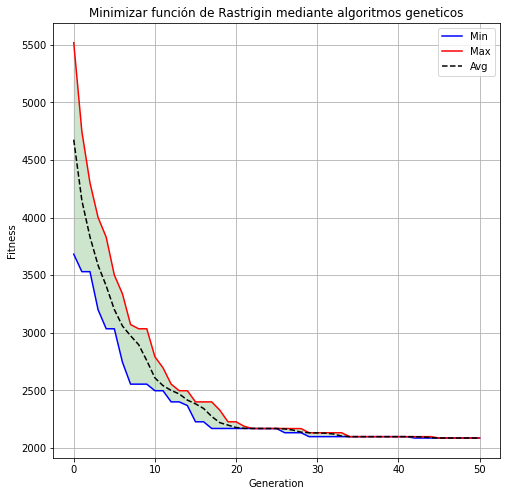

In [ ]:
plot_evolution(logs[1][0])

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=e519ef70-0417-4f93-b18c-a7992756a932' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>